In [1]:
import requests
import json
import re 
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score
from elasticsearch import Elasticsearch
elastic_client = Elasticsearch()

In [2]:
def search(query):
     url = 'http://localhost:9200/cran_experiment/_search'
     li_id=[]
     httpResp = requests.get(url, data=json.dumps(query), headers={"content-type":"application/json"})
     searchHits = json.loads(httpResp.text)["hits"]
     #print("Num\tRelevance Score\t\t ID\t Title")
     for idx, hit in enumerate(searchHits['hits']):
         #print("%s\t%s\t\t%s\t%s" %(idx + 1, hit['_score'], hit['_source']['id'], hit['_source']['title']))
         li_id.append(hit['_source']['id'])
     return li_id

In [3]:
with open('query.txt',encoding='utf-8') as f:
    lines1 = f.readlines()

In [4]:
with open('relevance.txt',encoding='utf-8') as f:
    lines2 = f.readlines()

In [5]:
str_query=" ".join(lines1)
str_relevance=" ".join(lines2)

In [6]:
substr1='.I '
li1 =re.finditer(substr1,str_query)
list1 = [x.start() for x in li1]

In [7]:
li_queries=[]
for i in range(list1.__len__()-1):
    li_queries.append(str_query[list1[i]+12:list1[i+1]-4].replace('\n ',' '))
substr11='.W\n what design factors can be used to control lift-drag'
li11 =re.finditer(substr11,str_query)
list11 = [x.start() for x in li11]
li_queries.append(str_query[list11[0]+4:len(str_query)-4].replace('\n ',' '))

In [8]:
li_relevance=[]
for i in str_relevance.split('\n'):
    li_relevance.append(list(map(int,i.strip().split(' ')[:2])))

In [9]:
query_nos=np.arange(1,226).tolist()
dict_index={}
for i in query_nos:
    dict_index[i]=[]

In [10]:
for i in query_nos:
    for j in li_relevance:
        if i==j[0]:
            dict_index[i].append(j[1])

In [12]:
import time
start = time.time()
average_precision=[]
for q in range(0,225):#li_queries:
    for i in range(0,11):
        for j in range(0,11):
            query = {      
                    "query": {
                        "multi_match": {
                            "query":li_queries[q] ,
                            "fields": ["title^{x}".format(x=i), "data^{y}".format(y=j)]
                         }
                     }
                }
            temp=search(query)
            li_temp=list(map(int,temp))
            li_temp1=[li_temp[:var] for var in range(1,11)]
            precision=[]
            y_actual=dict_index[q+1]
            indices=[]
            for var1 in li_temp1:
                true_positive=0
                for var2 in var1:
                    if var2 in y_actual:
                        true_positive+=1
                        indices.append(var1.index(var2))
                precision.append(true_positive/var1.__len__())
            indices=list(set(indices)) 
            if(indices.__len__()==0):
                average_precision.append([0,i,j])
            else:
                average_precision.append([sum(precision)/10,i,j])
    time.sleep(1)
end=time.time()
print(end-start)

417.941148519516


In [ ]:
average_precision.__len__()

In [13]:
max_map=0
max_i=0
max_j=0
temp=[]
li_map=[]
for i in range(121):
    temp=[]
    for j in range(i,average_precision.__len__(),121):
        temp.append(average_precision[j])
        if sum([x[0] for x in temp])/225>max_map:
            max_map=sum([x[0] for x in temp])/225
            max_i=temp[0][1]
            max_j=temp[0][2]
    li_map.append([sum([x[0] for x in temp])/225,temp[0][1],temp[0][2]])

In [ ]:
li_map.__len__()

In [14]:
li_map_sorted=li_map
li_map_sorted=sorted(li_map_sorted, key=lambda x: x[0],reverse=True)
df_map_sorted=pd.DataFrame({"MAP":[],"WEIGHTS":[]})
df_map=pd.DataFrame({"MAP":[],"WEIGHTS":[]})
for i in range(121):
    df_map_sorted.loc[i,"MAP"]=li_map_sorted[i][0]
    df_map_sorted.loc[i,"WEIGHTS"]="("+",".join(str(x) for x in li_map_sorted[i][1:])+")"
for i in range(121):
    df_map.loc[i,"MAP"]=li_map[i][0]
    df_map.loc[i,"WEIGHTS"]="("+",".join(str(x) for x in li_map[i][1:])+")"

In [15]:
df_map_sorted

,MAP,WEIGHTS
0,0.435478,"(9,8)"
1,0.434351,"(10,9)"
2,0.433877,"(8,7)"
3,0.433452,"(7,6)"
4,0.431284,"(1,1)"
...,...,...
116,0.343519,"(9,2)"
117,0.343519,"(10,0)"
118,0.343519,"(10,1)"
119,0.343519,"(10,2)"


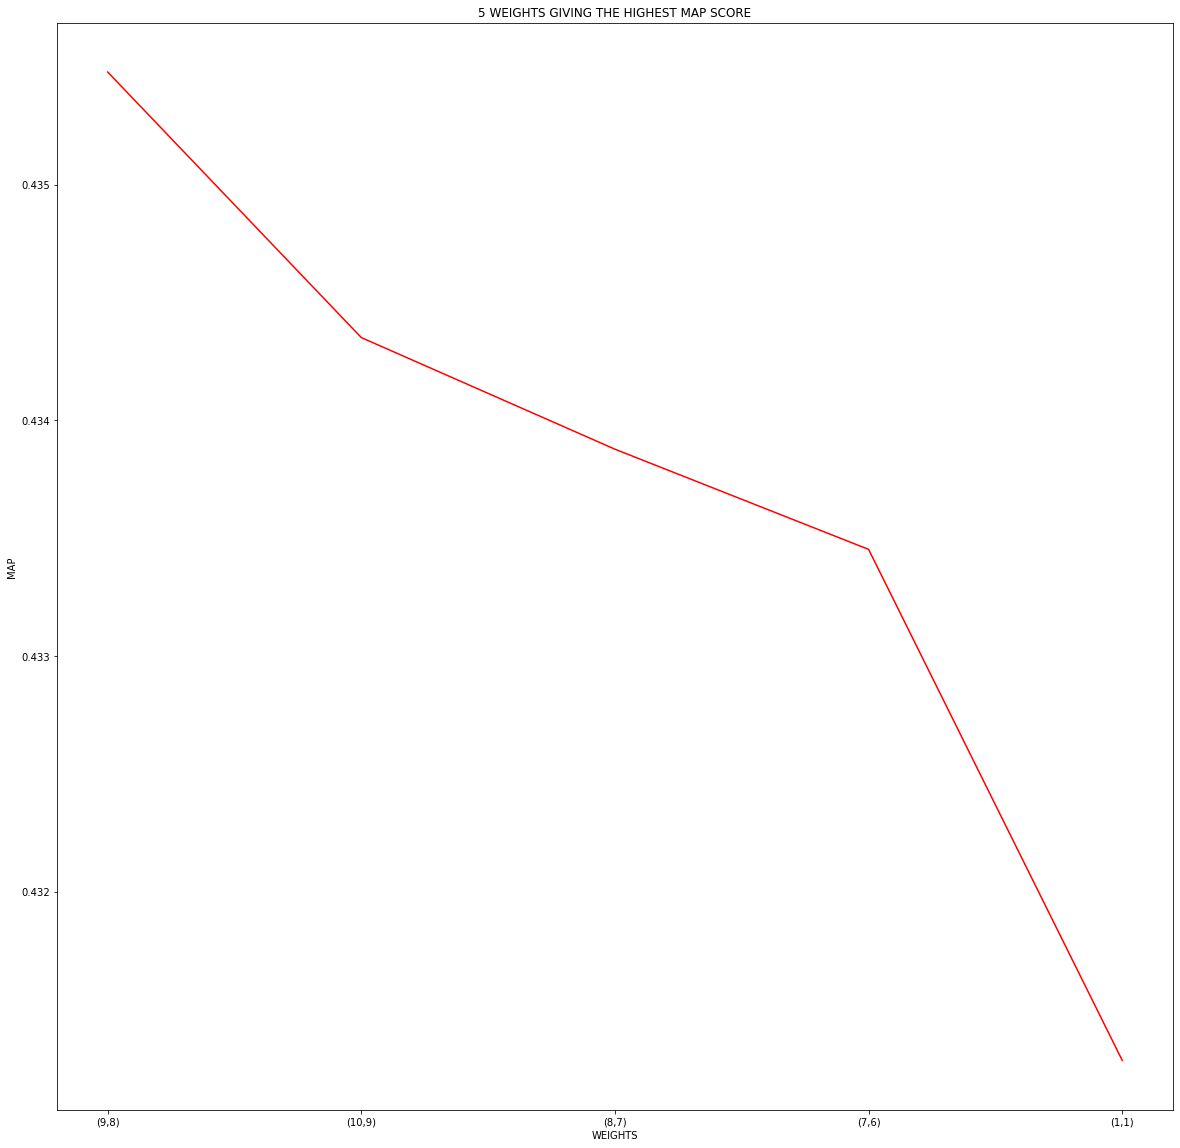

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
a4_dims = (20,20)
fig, ax = plt.subplots(figsize=a4_dims)
sns_plot = sns.lineplot(data=df_map_sorted[:5],x="WEIGHTS", y="MAP", markers=True, dashes=False, color="RED")
sns_plot.set(title='5 WEIGHTS GIVING THE HIGHEST MAP SCORE')
#plt.ylim(0, 0.5)
sns_plot.figure.savefig("max_map.png")

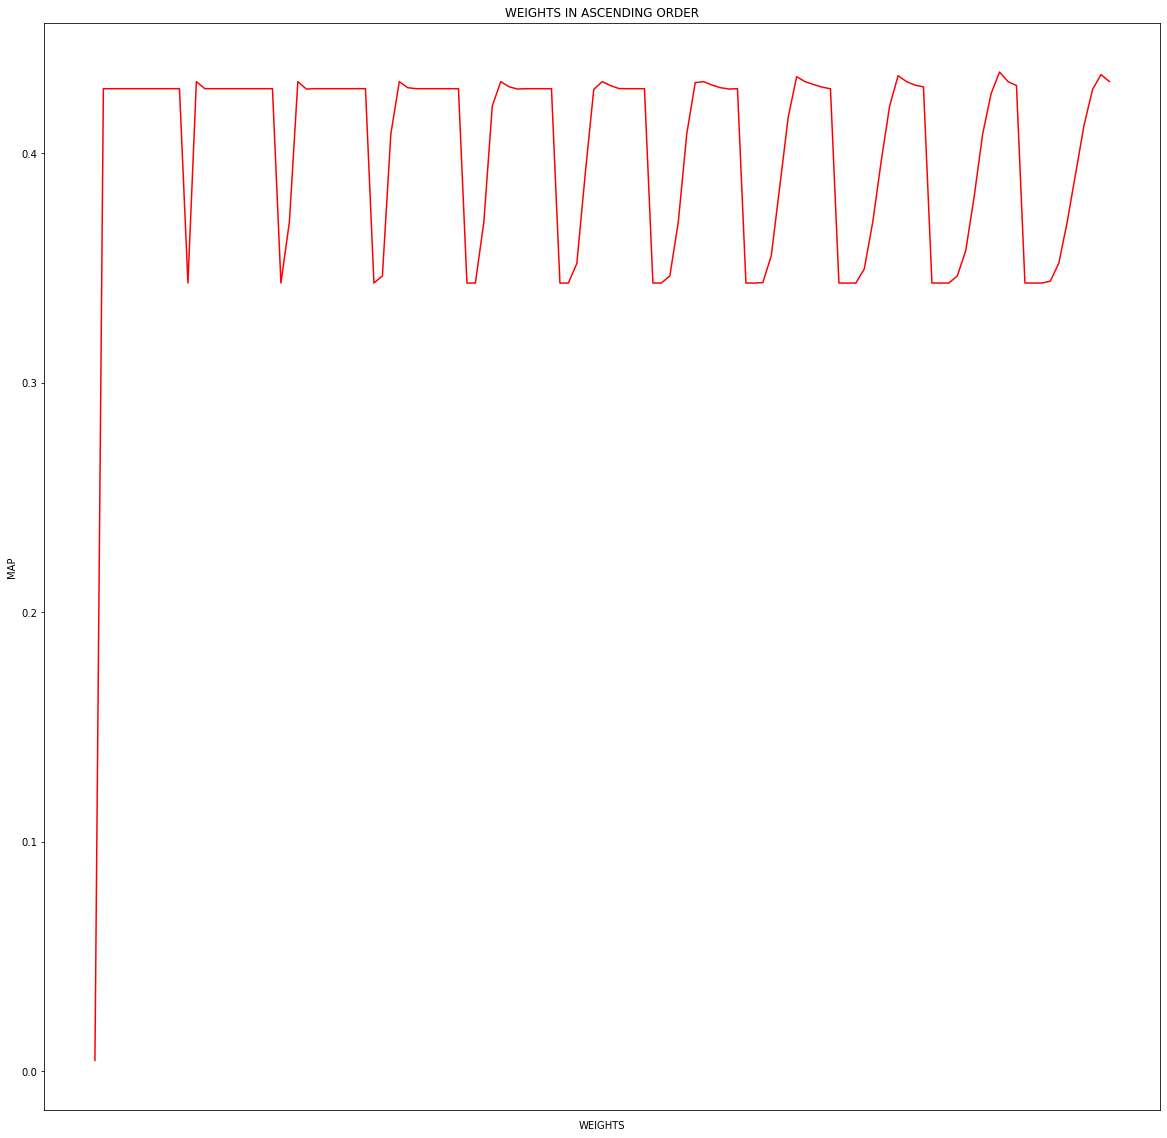

In [21]:
a4_dims = ()
ax = plt.subplots(figsize=(20,20))
g = sns.lineplot(data=df_map,x="WEIGHTS",y="MAP",color="red")
g.set(xticklabels=[])  
g.set(title='WEIGHTS IN ASCENDING ORDER')
g.tick_params(bottom=False) 
g.figure.savefig("all_map.png")

In [22]:
c=0
queries=[]
for i in average_precision:
    if i[1]==9 and i[2]==8:
        c+=1
        queries.append(['Query No '+str(c),i[0],i[1],i[2]])
temp=sorted(queries,key=lambda x:x[1],reverse=True)

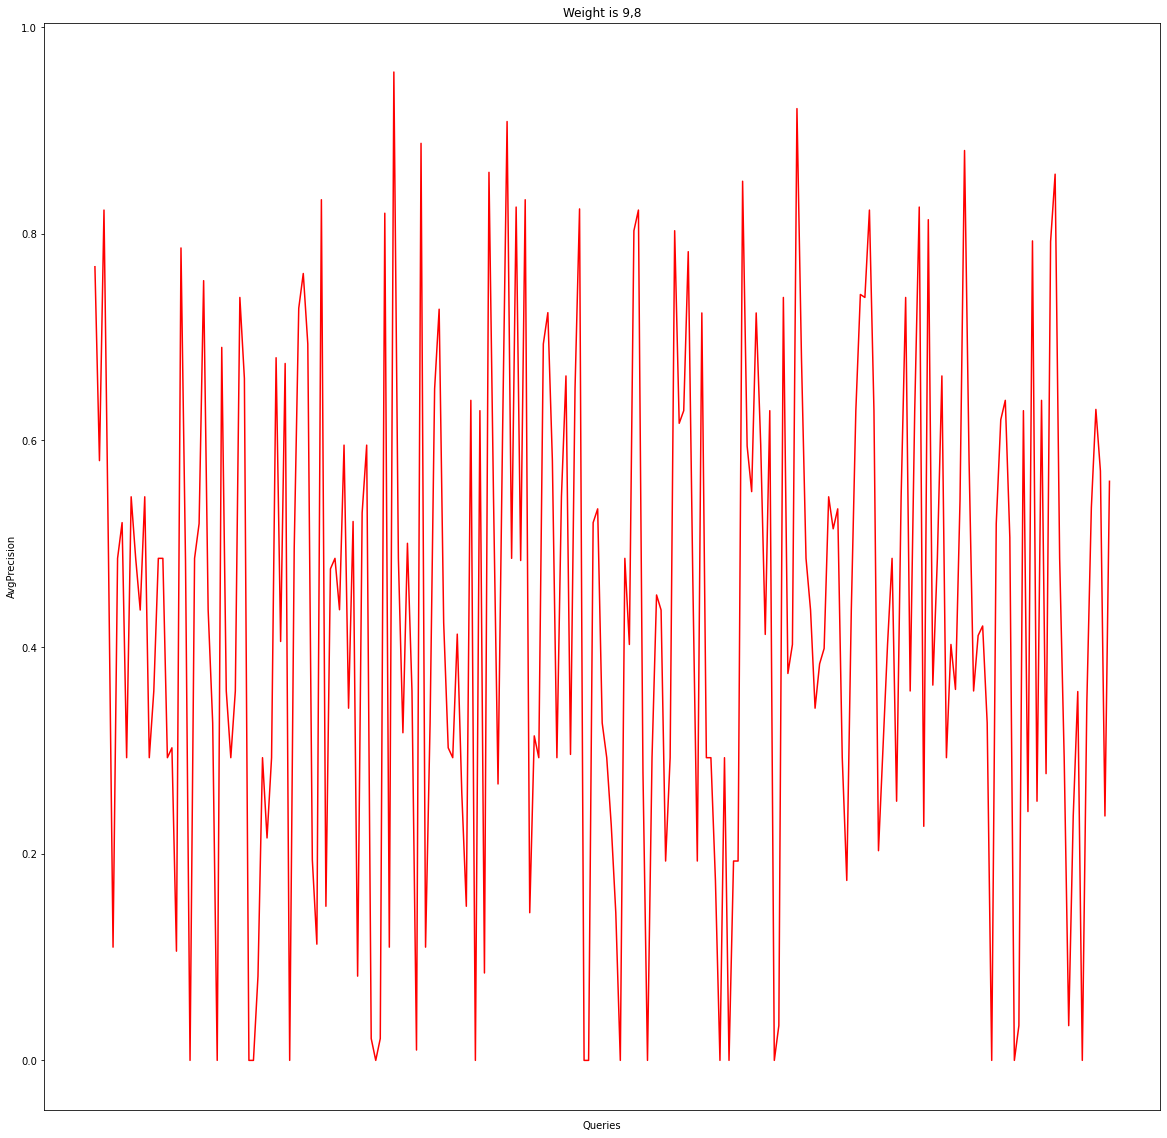

In [47]:
from sklearn import preprocessing
df=pd.DataFrame({"Queries":[],"AvgPrecision":[]})
for i in range(queries.__len__()):
    df.loc[i,"Queries"]=queries[i][0]
    df.loc[i,"AvgPrecision"]=queries[i][1]
#temp_avg=preprocessing.normalize([df["AvgPrecision"].values])
#temp_avg=[i for i in temp_avg.tolist()]
#temp_avg=[i for i in temp_avg[0]]
#df["AvgPrecision"]=temp_avg
df1=pd.DataFrame({"Queries":[],"AvgPrecision":[]})
for i in range(temp.__len__()):
    df1.loc[i,"Queries"]=temp[i][0]
    df1.loc[i,"AvgPrecision"]=temp[i][1]
a4_dims = ()
ax = plt.subplots(figsize=(20,20))
g = sns.lineplot(data=df,x="Queries",y="AvgPrecision",color="red")
g.set(xticklabels=[])  
g.set(title='Weight is 9,8')
g.tick_params(bottom=False) 
g.figure.savefig("all_map.png")

In [48]:
df1

,Queries,AvgPrecision
0,Query No 67,0.956389
1,Query No 156,0.920992
2,Query No 92,0.908492
3,Query No 73,0.887381
4,Query No 193,0.880437
...,...,...
220,Query No 141,0.000000
221,Query No 151,0.000000
222,Query No 199,0.000000
223,Query No 204,0.000000


In [49]:
start = time.time()
true_positive1=0
false_positive1=0
for q in range(0,225):#li_queries:
    query = {      
            "query": {
                "multi_match": {
                    "query":li_queries[q] ,
                    "fields": ["title^{x}".format(x=9), "data^{y}".format(y=8)]
                    }
                }
        }
    temp=search(query)
    li_temp=list(map(int,temp))
    indices=[]
    li_temp1=[li_temp[:var] for var in range(1,11)]
    y_actual=dict_index[q+1]
    for var1 in li_temp1[-1]:
        if var1 in y_actual:
            indices.append(var1)
            true_positive1+=1
        else:
            false_positive1+=1
end=time.time()
print(end-start)

4.831747770309448


In [50]:
start = time.time()
true_positive2=0
false_positive2=0
for q in range(0,225):#li_queries:
    query = {      
            "query": {
                "multi_match": {
                    "query":li_queries[q] ,
                    "fields": ["title^{x}".format(x=10), "data^{y}".format(y=9)]
                    }
                }
        }
    temp=search(query)
    li_temp=list(map(int,temp))
    indices=[]
    li_temp1=[li_temp[:var] for var in range(1,11)]
    y_actual=dict_index[q+1]
    for var1 in li_temp1[-1]:
        if var1 in y_actual:
            indices.append(var1)
            true_positive2+=1
        else:
            false_positive2+=1
end=time.time()
print(end-start)

3.2082483768463135


In [51]:
start = time.time()
true_positive3=0
false_positive3=0
for q in range(0,225):#li_queries:
    query = {      
            "query": {
                "multi_match": {
                    "query":li_queries[q] ,
                    "fields": ["title^{x}".format(x=8), "data^{y}".format(y=7)]
                    }
                }
        }
    temp=search(query)
    li_temp=list(map(int,temp))
    indices=[]
    li_temp1=[li_temp[:var] for var in range(1,11)]
    y_actual=dict_index[q+1]
    for var1 in li_temp1[-1]:
        if var1 in y_actual:
            indices.append(var1)
            true_positive3+=1
        else:
            false_positive3+=1
end=time.time()
print(end-start)

1.5263266563415527


In [67]:
df1=pd.DataFrame({"True_P":[],"False_P":[]})
df2=pd.DataFrame({"True_P":[],"False_P":[]})
df3=pd.DataFrame({"True_P":[],"False_P":[]})
df1.loc[0,"True_P"]=int(true_positive1)
df1.loc[0,"False_P"]=int(false_positive1)
df2.loc[0,"True_P"]=int(true_positive2)
df2.loc[0,"False_P"]=int(false_positive2)
df3.loc[0,"True_P"]=int(true_positive3)
df3.loc[0,"False_P"]=int(false_positive3)

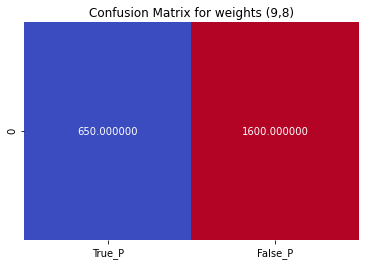

In [68]:
ax1 = sns.heatmap(df1, annot=True,fmt="f",cbar=False,cmap="coolwarm")
ax1.set(title='Confusion Matrix for weights (9,8)')
ax1.figure.savefig("conf1.png")


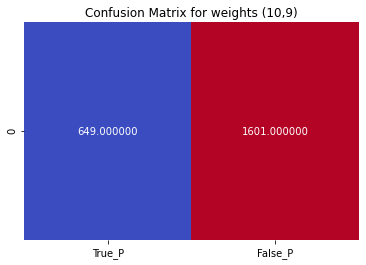

In [69]:
ax2 = sns.heatmap(df2, annot=True,fmt="f",cbar=False,cmap="coolwarm")
ax2.set(title='Confusion Matrix for weights (10,9)')
ax2.figure.savefig("conf2.png")

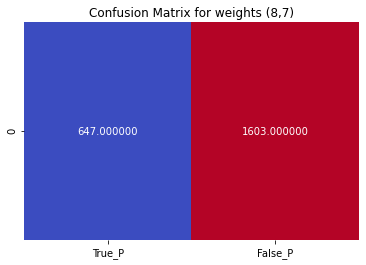

In [70]:
ax3 = sns.heatmap(df3, annot=True,fmt="f",cbar=False,cmap="coolwarm")
ax3.set(title='Confusion Matrix for weights (8,7)')
ax3.figure.savefig("conf3.png")

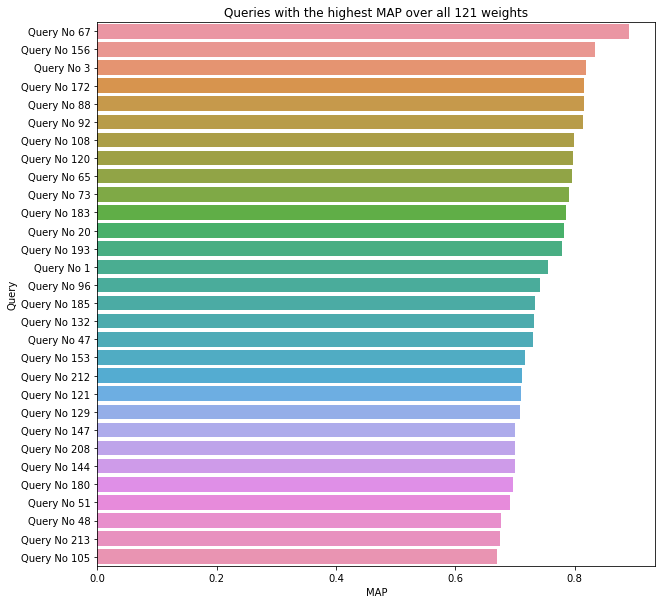

In [73]:
map_over_query=[]
c=1
for i in range(0,average_precision.__len__(),121):
    map_over_query.append([sum([x[0] for x in average_precision[i:i+121]])/121,"Query No "+str(c)])
    c+=1
map_over_query=sorted(map_over_query,key=lambda x:x[0],reverse=True)
df=pd.DataFrame({"Query":[],"MAP":[]})
df["Query"]=[x[1] for x in map_over_query]
df["MAP"]=[x[0] for x in map_over_query]
df=df[:30]
plt.figure(figsize=(10,10))
query=sns.barplot(x=df["MAP"],y=df["Query"],data=df)
query.set(title='Queries with the highest MAP over all 121 weights')
query.figure.savefig("queries_121.png")

In [56]:
df3=pd.DataFrame({"Weights":[],"MAP":[],"Precision":[]})

df3.loc[0,"Weights"]="9,8"
df3.loc[1,"Weights"]="10,9"
df3.loc[2,"Weights"]="8,7"

In [57]:
df3.loc[0,"MAP"]=df_map_sorted.loc[0,"MAP"]
df3.loc[1,"MAP"]=df_map_sorted.loc[1,"MAP"]
df3.loc[2,"MAP"]=df_map_sorted.loc[2,"MAP"]

In [58]:
df3.loc[0,"Precision"]=true_positive1/2250
df3.loc[1,"Precision"]=true_positive2/2250
df3.loc[2,"Precision"]=true_positive3/2250

In [59]:
df3.index=df3["Weights"]

In [60]:
df3.drop("Weights",axis=1,inplace=True)

In [61]:
df3

,MAP,Precision
Weights,,
"9,8",0.435478,0.288889
"10,9",0.434351,0.288444
"8,7",0.433877,0.287556
